In [1]:
# import os
# os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
# os.environ['CUDA_VISIBLE_DEVICES'] = ''

https://baseballsavant.mlb.com/csv-docs

In [2]:
import pandas as pd

df = pd.read_csv('./statcast-2019-04-10.csv')
df.shape

/Users/dgates/venvs/py3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(620579, 90)

In [3]:
df = df[df.game_year == 2018]
df.shape

(620560, 90)

In [4]:
player_ids = pd.read_excel('~/Downloads/SFBB-Player-ID-Map.xlsx')
player_ids.shape

(2177, 42)

In [5]:
with pd.option_context('display.max_columns', None):
    display(player_ids.head())

,IDPLAYER,PLAYERNAME,BIRTHDATE,FIRSTNAME,LASTNAME,TEAM,LG,POS,IDFANGRAPHS,FANGRAPHSNAME,MLBID,MLBNAME,CBSID,CBSNAME,RETROID,BREFID,NFBCID,NFBCNAME,ESPNID,ESPNNAME,KFFLNAME,DAVENPORTID,BPID,YAHOOID,YAHOONAME,MSTRBLLNAME,BATS,THROWS,FANTPROSNAME,LASTCOMMAFIRST,ROTOWIREID,FANDUELNAME,FANDUELID,DRAFTKINGSNAME,OTTONEUID,HQID,RAZZBALLNAME,FANTRAXID,FANTRAXNAME,ROTOWIRENAME,ALLPOS,NFBCLASTFIRST
0,aardsda01,David Aardsma,1981-12-27,David,Aardsma,NaN,NaN,P,1902,David Aardsma,430911.0,David Aardsma,479025.0,David Aardsma,aardd001,aardsda01,7307.0,David Aardsma,5933.0,David Aardsma,NaN,AARDSMA19811227A,45369.0,7307.0,David Aardsma,"Aardsma, David",R,R,David Aardsma,"Aardsma, David",7633.0,NaN,NaN,David Aardsma,4362.0,NaN,David Aardsma,NaN,NaN,David Aardsma,P,"Aardsma, David"
1,abadfe01,Fernando Abad,1985-12-17,Fernando,Abad,NaN,NaN,P,4994,Fernando Abad,472551.0,Fernando Abad,1723564.0,Fernando Abad,abadf001,abadfe01,8767.0,Fernando Abad,30417.0,Fernando Abad,NaN,ABAD19851217A,49706.0,8767.0,Fernando Abad,"Abad, Fernando",L,L,Fernando Abad,"Abad, Fernando",11285.0,Fernando Abad,12453.0,Fernando Abad,7372.0,3556.0,Fernando Abad,01viz,"Abad, Fernando",Fernando Abad,P,"Abad, Fernando"
2,abreual01,Albert Abreu,1995-09-26,Albert,Abreu,NYY,AL,P,sa828366,Albert Abreu,656061.0,Albert Abreu,2211792.0,Albert Abreu,NaN,abreual01,10546.0,Albert Abreu,36041.0,NaN,NaN,NaN,104651.0,NaN,NaN,"Abreu, Albert",R,R,Albert Abreu,"Abreu, Albert",14063.0,NaN,NaN,NaN,NaN,5762.0,Albert Abreu,NaN,NaN,Albert Abreu,P,"Abreu, Albert"
3,abreubo01,Bobby Abreu,1974-03-11,Bobby,Abreu,NaN,NaN,OF,945,Bobby Abreu,110029.0,Bobby Abreu,7367.0,Bobby Abreu,abreb001,abreubo01,5698.0,Bobby Abreu,3537.0,Bobby Abreu,Bobby Abreu,ABREU19740311A,650.0,5698.0,Bobby Abreu,"Abreu, Bobby",L,R,Bobby Abreu,"Abreu, Bobby",NaN,NaN,NaN,NaN,8984.0,NaN,Bobby Abreu,NaN,NaN,NaN,OF,"Abreu, Bobby"
4,abreujo02,Jose Abreu,1987-01-29,Jose,Abreu,CHW,AL,1B,15676,Jose Abreu,547989.0,Jose Abreu,2106364.0,Jose Abreu,abrej003,abreujo02,9540.0,Jose Abreu,33095.0,Jose Abreu,Jose Abreu,ABREUcubaJ01,102005.0,9540.0,Jose Abreu,"Abreu, Jose",R,R,Jose Abreu,"Abreu, Jose",11341.0,Jose Abreu,49523.0,Jose Abreu,18286.0,4515.0,Jose Abreu,02i2e,"Abreu, Jose","Abreu, Jose",1B,"Abreu, Jose"


In [6]:
player_ids = player_ids[['MLBID', 'MLBNAME', 'TEAM', 'POS']]
batter_ids = player_ids.copy()
batter_ids.columns = [f'batter_{c.lower()}' for c in batter_ids.columns]
pitcher_ids = player_ids.copy()
pitcher_ids.columns = [f'pitcher_{c.lower()}' for c in pitcher_ids.columns]

In [7]:
df = df.merge(batter_ids, left_on='batter', right_on='batter_mlbid', how='left')
df = df.merge(pitcher_ids, left_on='pitcher', right_on='pitcher_mlbid', how='left')
df.shape

(620560, 98)

In [8]:
df[['batter', 'batter_mlbname']].drop_duplicates().shape

(969, 2)

In [9]:
df[['pitcher', 'pitcher_mlbname']].drop_duplicates().isnull().sum(), \
df[['batter', 'batter_mlbname']].drop_duplicates().isnull().sum()

(pitcher              0
 pitcher_mlbname    202
 dtype: int64, batter              0
 batter_mlbname    138
 dtype: int64)

In [10]:
with pd.option_context('display.max_columns', None):
    display(df[df.batter_mlbname.isnull()].sample(20).head())

,at_bat_number,away_score,away_team,ax,ay,az,babip_value,balls,bat_score,batter,bb_type,break_angle_deprecated,break_length_deprecated,des,description,effective_speed,error,estimated_ba_using_speedangle,estimated_woba_using_speedangle,events,fielder_2,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,fld_score,game_date,game_pk,game_type,game_year,hc_x,hc_y,hit_distance_sc,hit_location,home_score,home_team,if_fielding_alignment,inning,inning_topbot,iso_value,launch_angle,launch_speed,launch_speed_angle,of_fielding_alignment,on_1b,on_2b,on_3b,outs_when_up,p_throws,pfx_x,pfx_z,pitch_name,pitch_number,pitch_type,pitcher,pitcher.1,plate_x,plate_z,player_name,post_away_score,post_bat_score,post_fld_score,post_home_score,release_extension,release_pos_x,release_pos_y,release_pos_z,release_speed,release_spin_rate,spin_dir,spin_rate_deprecated,stand,strikes,sv_id,sz_bot,sz_top,tfs_deprecated,tfs_zulu_deprecated,type,umpire,vx0,vy0,vz0,woba_denom,woba_value,zone,batter_mlbid,batter_mlbname,batter_team,batter_pos,pitcher_mlbid,pitcher_mlbname,pitcher_team,pitcher_pos
474565,39.0,0.0,TOR,-9.7875,29.7813,-13.5724,NaN,0.0,0.0,620446.0,NaN,NaN,NaN,NaN,swinging_strike,98.579,NaN,NaN,NaN,NaN,519222.0,519222.0,595885.0,650402.0,609280.0,544369.0,458731.0,543305.0,435522.0,7.0,2018-08-18,531263.0,R,2018.0,NaN,NaN,NaN,NaN,7.0,NYY,Standard,5.0,Top,NaN,NaN,NaN,NaN,Standard,649557.0,NaN,NaN,1.0,R,-0.5999,1.2812,4-Seam Fastball,1.0,FF,622663.0,622663.0,-0.1094,2.9121,Luis Severino,0.0,0.0,7.0,7.0,6.403,-2.3043,54.0953,5.8833,98.0,2396.0,NaN,NaN,L,0.0,180818_185749,1.3256,2.9666,NaN,NaN,S,NaN,7.3315,-142.6157,-5.5646,NaN,NaN,2.0,NaN,NaN,NaN,NaN,622663.0,Luis Severino,NYY,P
438575,16.0,1.0,COL,-8.6053,24.9808,-14.6965,NaN,0.0,3.0,571679.0,NaN,NaN,NaN,NaN,foul,93.636,NaN,NaN,NaN,NaN,455104.0,455104.0,435622.0,518934.0,571448.0,596115.0,467827.0,571595.0,471865.0,1.0,2018-07-08,530751.0,R,2018.0,NaN,NaN,210.0,NaN,3.0,SEA,Standard,2.0,Bot,NaN,11.0,96.2,NaN,Standard,NaN,NaN,NaN,0.0,R,-0.5763,1.3178,4-Seam Fastball,2.0,FF,622608.0,622608.0,0.6313,2.3151,Antonio Senzatela,1.0,3.0,1.0,3.0,6.080,-1.9588,54.4198,6.1767,93.5,2066.0,NaN,NaN,R,1.0,180708_204501,1.5145,3.7892,NaN,NaN,S,NaN,7.8874,-135.8895,-7.1117,NaN,NaN,6.0,NaN,NaN,NaN,NaN,622608.0,Antonio Senzatela,COL,P
153243,60.0,2.0,PHI,-18.2119,29.1633,-20.3752,0.0,2.0,2.0,621044.0,ground_ball,NaN,NaN,"Jesmuel Valentin grounds out, second baseman K...",hit_into_play,94.358,NaN,0.179,0.162,field_out,506747.0,506747.0,500874.0,543939.0,572761.0,594824.0,641933.0,502054.0,451594.0,9.0,2018-05-18,530073.0,R,2018.0,140.29,154.25,56.0,4.0,9.0,STL,Standard,7.0,Top,0.0,3.0,74.5,2.0,Standard,NaN,NaN,NaN,1.0,R,-1.3260,0.8802,2-Seam Fastball,3.0,FT,605154.0,605154.0,-0.8645,2.3822,John Brebbia,2.0,2.0,9.0,9.0,6.637,-2.4012,53.8614,5.4477,93.7,2117.0,NaN,NaN,L,0.0,180519_042528,1.2882,3.4715,NaN,NaN,X,NaN,6.9699,-136.2907,-4.1800,1.0,0.0,11.0,NaN,NaN,NaN,NaN,605154.0,John Brebbia,STL,P
619904,10.0,0.0,CHC,-9.2590,33.9053,-9.5914,NaN,0.0,0.0,623520.0,NaN,NaN,NaN,NaN,ball,97.841,NaN,NaN,NaN,NaN,571851.0,571851.0,475582.0,506703.0,543685.0,607208.0,645302.0,572191.0,547180.0,0.0,2018-09-08,531512.0,R,2018.0,NaN,NaN,NaN,NaN,0.0,WSH,Standard,2.0,Top,NaN,NaN,NaN,NaN,Standard,NaN,NaN,NaN,1.0,R,-0.5036,1.4700,4-Seam Fastball,1.0,FF,622446.0,622446.0,1.5052,1.5397,Jefry Rodriguez,0.0,0.0,0.0,0.0,6.883,-1.7979,53.6162,6.7251,97.4,2477.0,NaN,NaN,R,0.0,NaN,1.8035,3.5897,NaN,NaN,B,NaN,10.1213,-141.1645,-11.8578,NaN,NaN,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
600555,59.0,6.0,PIT,-14.6799,28.9134,-15.1920,0.0,1.0,4.0,621550.0,NaN,NaN,NaN,Patrick Wisdom strikes out swinging.,swinging_strike,94.190,NaN,NaN,NaN,strikeout,465041.0,465041.0,605137.0,543281.0,592567.0,474568.0,572816.0,516782.0,624428.0,6.0,2018-09-10,531564.0,R,2018.0,NaN,NaN,NaN,2.0,4.0,STL,Standard,7.0,Bot,0.0,NaN,NaN,NaN,Standard,NaN,NaN,NaN,2.0,R,-0.9909,1.2958,4-Seam Fastball,4.0,FF,593144.0,593144.0,-0.1008,3.3644,Richard Rodriguez,6.0,4

In [11]:
player_ids[player_ids.MLBNAME.str.lower().str.contains('nolan').fillna(False)]

,MLBID,MLBNAME,TEAM,POS
76,571448.0,Nolan Arenado,COL,3B
1655,460099.0,Nolan Reimold,NaN,OF


In [12]:
with pd.option_context('display.max_columns', None):
    display(df.head())

,at_bat_number,away_score,away_team,ax,ay,az,babip_value,balls,bat_score,batter,bb_type,break_angle_deprecated,break_length_deprecated,des,description,effective_speed,error,estimated_ba_using_speedangle,estimated_woba_using_speedangle,events,fielder_2,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,fld_score,game_date,game_pk,game_type,game_year,hc_x,hc_y,hit_distance_sc,hit_location,home_score,home_team,if_fielding_alignment,inning,inning_topbot,iso_value,launch_angle,launch_speed,launch_speed_angle,of_fielding_alignment,on_1b,on_2b,on_3b,outs_when_up,p_throws,pfx_x,pfx_z,pitch_name,pitch_number,pitch_type,pitcher,pitcher.1,plate_x,plate_z,player_name,post_away_score,post_bat_score,post_fld_score,post_home_score,release_extension,release_pos_x,release_pos_y,release_pos_z,release_speed,release_spin_rate,spin_dir,spin_rate_deprecated,stand,strikes,sv_id,sz_bot,sz_top,tfs_deprecated,tfs_zulu_deprecated,type,umpire,vx0,vy0,vz0,woba_denom,woba_value,zone,batter_mlbid,batter_mlbname,batter_team,batter_pos,pitcher_mlbid,pitcher_mlbname,pitcher_team,pitcher_pos
0,115.0,7.0,BAL,-10.4412,28.4190,-15.7096,0.0,0.0,3.0,592122.0,NaN,NaN,NaN,Tyler Austin strikes out swinging.,swinging_strike,90.722,NaN,NaN,NaN,strikeout,543376.0,543376.0,641820.0,570731.0,542921.0,592518.0,458675.0,430945.0,623993.0,7.0,2018-04-06,529509.0,R,2018.0,NaN,NaN,NaN,2.0,3.0,NYY,Standard,14.0,Bot,0.0,NaN,NaN,NaN,Standard,NaN,NaN,NaN,2.0,R,-0.7285,1.3626,4-Seam Fastball,3.0,FF,542960.0,542960.0,0.4224,3.4716,Brad Brach,7.0,3.0,7.0,3.0,5.839,-2.5964,54.6608,6.1537,91.7,2195.0,NaN,NaN,R,2.0,NaN,1.4472,3.2454,NaN,NaN,S,NaN,9.0707,-133.0662,-3.7404,1.0,0.0,12.0,592122.0,Tyler Austin,MIN,1B,542960.0,Brad Brach,NaN,P
1,115.0,7.0,BAL,-10.1062,29.7698,-9.9198,NaN,0.0,3.0,592122.0,NaN,NaN,NaN,NaN,foul,90.970,NaN,NaN,NaN,NaN,543376.0,543376.0,641820.0,570731.0,542921.0,592518.0,458675.0,430945.0,623993.0,7.0,2018-04-06,529509.0,R,2018.0,NaN,NaN,NaN,NaN,3.0,NYY,Standard,14.0,Bot,NaN,NaN,NaN,NaN,Standard,NaN,NaN,NaN,2.0,R,-0.6601,1.7870,4-Seam Fastball,2.0,FF,542960.0,542960.0,0.9707,2.5324,Brad Brach,7.0,3.0,7.0,3.0,5.781,-2.6948,54.7186,6.0787,92.3,2157.0,NaN,NaN,R,1.0,NaN,1.5890,3.4670,NaN,NaN,S,NaN,10.5851,-133.7651,-6.8526,NaN,NaN,12.0,592122.0,Tyler Austin,MIN,1B,542960.0,Brad Brach,NaN,P
2,115.0,7.0,BAL,-7.6452,30.1096,-10.5460,NaN,0.0,3.0,592122.0,NaN,NaN,NaN,NaN,called_strike,91.006,NaN,NaN,NaN,NaN,543376.0,543376.0,641820.0,570731.0,542921.0,592518.0,458675.0,430945.0,623993.0,7.0,2018-04-06,529509.0,R,2018.0,NaN,NaN,NaN,NaN,3.0,NYY,Standard,14.0,Bot,NaN,NaN,NaN,NaN,Standard,NaN,NaN,NaN,2.0,R,-0.5382,1.7198,4-Seam Fastball,1.0,FF,542960.0,542960.0,-0.9484,2.3415,Brad Brach,7.0,3.0,7.0,3.0,5.521,-2.8473,54.9783,6.1860,92.6,2265.0,NaN,NaN,R,0.0,NaN,1.6351,3.4636,NaN,NaN,S,NaN,5.8862,-134.4473,-7.4873,NaN,NaN,13.0,592122.0,Tyler Austin,MIN,1B,542960.0,Brad Brach,NaN,P
3,114.0,7.0,BAL,1.4834,24.1554,-28.0396,0.0,2.0,3.0,591720.0,line_drive,NaN,NaN,Ronald Torreyes lines out to second baseman Jo...,hit_into_play,83.781,NaN,0.458,0.406,field_out,543376.0,543376.0,641820.0,570731.0,542921.0,592518.0,458675.0,430945.0,623993.0,7.0,2018-04-06,529509.0,R,2018.0,144.14,135.76,160.0,4.0,3.0,NYY,Standard,14.0,Bot,0.0,18.0,65.1,2.0,Strategic,NaN,NaN,NaN,1.0,R,0.3480,0.3493,Slider,5.0,SL,542960.0,542960.0,1.3797,1.4883,Brad Brach,7.0,3.0,7.0,3.0,5.385,-3.3153,55.1144,5.9143,85.4,2590.0,NaN,NaN,R,2.0,NaN,1.2260,3.1146,NaN,NaN,X,NaN,10.1633,-123.7968,-4.6843,1.0,0.0,14.0,591720.0,Ronal Torreyes,MIN,SS,542960.0,Brad Brach,NaN,P
4,114.0,7.0,BAL,-8.2223,30.6771,-10.1566,NaN,2.0,3.0,591720.0,NaN,NaN,NaN,NaN,called_strike,90.912,NaN,NaN,NaN,NaN,543376.0,543376.0,641820.0,570731.0,542921.0,592518.0,458675.0,430945.0,623993.0,7.0,2018-04-06,529509.0,R,2018.0,NaN,NaN,NaN,NaN,3.0,NYY,Standard,14.0,Bot,NaN,NaN,NaN,NaN,Standard,NaN,NaN,NaN,1.0,R,-0.5107,1.7237,4-Seam Fastball,4.0,FF,542960.0,542960.0,0.7218,1.6812,Brad Brach,7.0,3.0,7.0,3.0,5.824,-2.7254,54.6751

In [13]:
# df = df[df.type.ne('B')]
df = df[~df.game_pk.isnull()]
df.shape

(620560, 98)

# Feature engineering

In [14]:
df.events.unique()

array(['strikeout', nan, 'field_out', 'home_run', 'sac_bunt', 'single',
       'walk', 'other_out', 'force_out', 'grounded_into_double_play',
       'double', 'double_play', 'hit_by_pitch', 'field_error',
       'fielders_choice_out', 'triple', 'sac_fly',
       'strikeout_double_play', 'fielders_choice',
       'pickoff_caught_stealing_2b', 'caught_stealing_2b', 'pickoff_1b',
       'caught_stealing_3b', 'caught_stealing_home', 'catcher_interf',
       'triple_play', 'sac_fly_double_play', 'pickoff_2b',
       'sac_bunt_double_play', 'pickoff_3b', 'pickoff_caught_stealing_3b',
       'pickoff_caught_stealing_home', 'run', 'batter_interference'],
      dtype=object)

In [15]:
target_events = [
    'single',
    'double',
    'triple',
    'home_run',
    'walk',
]
target_events = {event: i for i, event in enumerate(target_events, start=1)}
on_base_event_map = {event: target_events.get(event, 0) for event in df.events.unique()}
df['target'] = df.events.map(on_base_event_map)

In [16]:
on_base_event_map

{'batter_interference': 0,
 'catcher_interf': 0,
 'caught_stealing_2b': 0,
 'caught_stealing_3b': 0,
 'caught_stealing_home': 0,
 'double': 2,
 'double_play': 0,
 'field_error': 0,
 'field_out': 0,
 'fielders_choice': 0,
 'fielders_choice_out': 0,
 'force_out': 0,
 'grounded_into_double_play': 0,
 'hit_by_pitch': 0,
 'home_run': 4,
 nan: 0,
 'other_out': 0,
 'pickoff_1b': 0,
 'pickoff_2b': 0,
 'pickoff_3b': 0,
 'pickoff_caught_stealing_2b': 0,
 'pickoff_caught_stealing_3b': 0,
 'pickoff_caught_stealing_home': 0,
 'run': 0,
 'sac_bunt': 0,
 'sac_bunt_double_play': 0,
 'sac_fly': 0,
 'sac_fly_double_play': 0,
 'single': 1,
 'strikeout': 0,
 'strikeout_double_play': 0,
 'triple': 3,
 'triple_play': 0,
 'walk': 5}

In [17]:
df['runner_on_first'] = (~df.on_1b.isnull()).astype(int)
df['runner_on_second'] = (~df.on_2b.isnull()).astype(int)
df['runner_on_third'] = (~df.on_3b.isnull()).astype(int)

In [18]:
total_pitches = df.loc[:, ['game_pk', 'at_bat_number', 'pitch_number', 'pitcher']]
total_pitches['counter'] = 1

In [19]:
total_pitches.sort_values(['game_pk', 'pitcher', 'at_bat_number', 'pitch_number'], inplace=True)
total_pitches['total_pitch_number'] = total_pitches.groupby([
    'game_pk', 'pitcher'
], as_index=False).counter.cumsum()
with pd.option_context('display.max_rows', None):
    display(total_pitches.head(100))

,game_pk,at_bat_number,pitch_number,pitcher,counter,total_pitch_number
31131,529406.0,1.0,1.0,502042.0,1,1
31119,529406.0,2.0,1.0,502042.0,1,2
31104,529406.0,2.0,2.0,502042.0,1,3
31088,529406.0,2.0,3.0,502042.0,1,4
31085,529406.0,3.0,1.0,502042.0,1,5
31069,529406.0,3.0,2.0,502042.0,1,6
31055,529406.0,3.0,3.0,502042.0,1,7
31047,529406.0,3.0,4.0,502042.0,1,8
31023,529406.0,3.0,5.0,502042.0,1,9
31018,529406.0,3.0,6.0,502042.0,1,10


In [20]:
df = df.merge(total_pitches, on=['game_pk', 'pitcher', 'at_bat_number', 'pitch_number'])

In [21]:
stats = pd.read_csv('baseballdatabank-2019.2/core/Batting.csv')
ids = pd.read_excel('/Users/dgates/Downloads/SFBB-Player-ID-Map.xlsx')
stats = stats.merge(ids, left_on='playerID', right_on='IDPLAYER')
stats = stats[stats.yearID == 2018]
stats.shape

(1205, 64)

In [22]:
import numpy as np
eligible_batters = stats[stats.AB > 100].MLBID
df['batter_id'] = np.where(df.batter.isin(eligible_batters), df.batter, 0)

In [23]:
df.batter_id.describe()

count    620560.000000
mean     500648.075728
std      168980.341938
min           0.000000
25%      460077.000000
50%      543939.000000
75%      596142.000000
max      665742.000000
Name: batter_id, dtype: float64

In [24]:
df[['batter_id', 'batter_mlbname']].drop_duplicates().shape

(831, 2)

In [75]:
pitching_stats = pd.read_csv('baseballdatabank-2019.2/core/Pitching.csv')
pitching_stats = pitching_stats[pitching_stats.yearID == 2018]
pitching_stats = pitching_stats.merge(ids, left_on='playerID', right_on='IDPLAYER')
pitching_stats.shape

(657, 72)

In [98]:
eligible_pitchers = pitching_stats[pitching_stats.IPouts > (20*3)].PLAYERNAME
df['pitcher_id'] = np.where(df.player_name.str.lower().isin(eligible_pitchers.str.lower()), df.pitcher, 0)
len(eligible_pitchers), df.pitcher_id.nunique()

(473, 435)

In [99]:
numeric_features = [
    'bat_score',  # these are pre-pitch
    'fld_score',  # these are pre-pitch
    'balls',
    'strikes',
    'outs_when_up',
    'pitch_number',
    'inning',
    'total_pitch_number',
    'at_bat_number'
]

categorical_features = [
    'if_fielding_alignment',
    'of_fielding_alignment',
    'inning_topbot',  # home field advantage
    'pitch_name',
    'zone',
    'pitcher_id',
    'batter_id',  # mapping of batters with less than 100 AB to 0
    'game_type',
    'stand',  # for batter
    'runner_on_first',
    'runner_on_second',
    'runner_on_third',
    'away_team',
    'home_team'
]

target = 'target'

In [100]:
from sklearn.base import TransformerMixin

class Encoder(TransformerMixin):
    def __init__(self):
        self.mappings = {}

    def fit(self, X):
        self.mappings = {
            feature: {v: i for i, v in enumerate(X[feature].unique())}
            for feature in X.columns
        }
        return self
    
    def transform(self, X):
        return {
            f'{feature}_input': X[feature].map(self.mappings[feature]).values
            for feature in X.columns
            if feature in self.mappings
        }

    def inverse_transform(self, X, feature):
        return X.map({v: k for k, v in self.mappings[feature].items()})
    
    def get_feature_dim(self, feature):
        return len(self.mappings[feature])

# Recurrent model

In [101]:
encoder = Encoder()
encoder.fit(df[categorical_features])

In [102]:
# numeric_features.remove('pitch_number')

In [103]:
if True:
    sample_key = df[['game_pk', 'at_bat_number']].apply(lambda x: hash(tuple(x)) % 100, axis=1)
    df_sample = df[sample_key <= 10]
else:
    df_sample = df

In [104]:
df_sample.shape

(155150, 106)

In [105]:
from tqdm import tqdm_notebook as tqdm

df_sample.sort_values(['game_pk', 'at_bat_number', 'pitch_number'], inplace=True)

groups = df_sample.groupby([
    'game_pk', 'at_bat_number'
], as_index=False)
np.random.shuffle(list(groups))

X_train = []
y_train = []

def featurize_at_bat(group):
    (game_pk, at_bat_number), group_df = group
    x = encoder.transform(group_df[categorical_features])
    x['numeric_inputs'] = group_df[numeric_features].values
    y = np.zeros((len(target_events) + 1,))
    assert len(group_df.target.unique()) <= 2
    y[group_df.target.max()] = 1
    return x, y, len(x['numeric_inputs'])

/Users/dgates/venvs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [106]:
import multiprocessing as mp
import numpy as np

pool = mp.Pool(2 * mp.cpu_count())
res = pool.imap_unordered(featurize_at_bat, tqdm(groups))
res = sorted(res, key=lambda x: x[-1])
X_train, y_train, batch_lens = zip(*res)

HBox(children=(IntProgress(value=0, max=39743), HTML(value='')))

In [107]:
len(X_train), len(y_train)

(39743, 39743)

## create the batches

In [108]:
import numpy as np

# assign each at-bat an ID so that each batch
# has roughly 32 pitches
batch_ids = np.cumsum(batch_lens) // 32
len(batch_ids), len(set(batch_ids))

(39743, 4849)

In [109]:
from itertools import groupby
i = iter(batch_ids)
gb = groupby(zip(X_train, y_train), key=lambda x: next(i))

In [110]:
batch_id, batch = next(gb)
xs, ys = zip(*list(batch))
xs, ys

(({'away_team_input': array([19]),
   'batter_id_input': array([188]),
   'game_type_input': array([0]),
   'home_team_input': array([20]),
   'if_fielding_alignment_input': array([0]),
   'inning_topbot_input': array([1]),
   'numeric_inputs': array([[0., 0., 0., 0., 0., 1., 1., 1., 1.]]),
   'of_fielding_alignment_input': array([0]),
   'pitch_name_input': array([0]),
   'pitcher_id_input': array([241]),
   'runner_on_first_input': array([0]),
   'runner_on_second_input': array([0]),
   'runner_on_third_input': array([0]),
   'stand_input': array([0]),
   'zone_input': array([8])},
  {'away_team_input': array([19]),
   'batter_id_input': array([278]),
   'game_type_input': array([0]),
   'home_team_input': array([20]),
   'if_fielding_alignment_input': array([0]),
   'inning_topbot_input': array([1]),
   'numeric_inputs': array([[ 4.,  0.,  0.,  0.,  2.,  1.,  7.,  6., 49.]]),
   'of_fielding_alignment_input': array([0]),
   'pitch_name_input': array([1]),
   'pitcher_id_input': arra

In [111]:
import numpy as np
from keras.preprocessing.sequence import pad_sequences

input_features = list(xs[0].keys())
batch_id, batch = next(gb)
xs, ys = zip(*list(batch))

X_batch = {}

for f in input_features:
    X_batch[f] = pad_sequences([x[f] for x in xs])
y_batch = np.array(ys)

X_batch, y_batch

({'away_team_input': array([[ 1],
         [13],
         [13],
         [16],
         [16],
         [11],
         [26],
         [26],
         [26],
         [14],
         [14],
         [14],
         [14],
         [14],
         [21],
         [21],
         [21],
         [10],
         [10],
         [19],
         [19],
         [ 1],
         [ 1],
         [15],
         [15],
         [18],
         [13],
         [13],
         [13],
         [16],
         [11],
         [11]], dtype=int32), 'batter_id_input': array([[275],
         [ 58],
         [340],
         [ 53],
         [ 49],
         [ 79],
         [117],
         [ 18],
         [ 57],
         [ 12],
         [  9],
         [  1],
         [ 59],
         [  2],
         [319],
         [ 67],
         [119],
         [160],
         [265],
         [234],
         [204],
         [ 20],
         [275],
         [132],
         [207],
         [238],
         [311],
         [  1],
         [126],
     

In [112]:
X_batch['numeric_inputs'].shape, X_batch['batter_id_input'].shape, y_batch.shape

((32, 1, 9), (32, 1), (32, 6))

In [113]:
def batch_generator(gb):
    for batch_id, batch in gb:
        xs, ys = zip(*list(batch))
        X_batch = {}
        for f in input_features:
            X_batch[f] = pad_sequences([x[f] for x in xs])
        yield X_batch, np.array(ys)
        

In [114]:
i = iter(batch_ids)
gb = groupby(zip(X_train, y_train), key=lambda x: next(i))
batches = list(batch_generator(gb))

In [115]:
len(batches)

4849

In [116]:
batches[0][0]['numeric_inputs'].shape, batches[0][1].shape

((31, 1, 9), (31, 6))

## build model

In [117]:
import keras
import keras.backend as K

# LSTM input
Sum = keras.layers.Lambda(lambda x: K.sum(x, axis=1))
def Attention(X):
    # https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf
    W = keras.layers.Dense(K.int_shape(X)[-1], activation='tanh', name='W')
    u = W(X)
    u_w = keras.layers.Dense(1, activation='linear', name='u_w')
    attention = keras.layers.Softmax(1)(u_w(u))
    X_attended = keras.layers.Multiply()([X, attention])
    return Sum(X_attended), attention


categorical_dimmensions = {
    'batter_id': 2,
    'pitcher_id': 2,
}

numeric_input = keras.layers.Input((None, len(numeric_features),), name='numeric_inputs')
X_numeric_input = keras.layers.BatchNormalization()(numeric_input)

categorical_inputs = []
embeddings = {}
for feature in categorical_features:
    input_ = keras.layers.Input((None,), name=f'{feature}_input')
    output_dim = categorical_dimmensions.get(feature, 1)
    embedding =  keras.layers.Embedding(input_dim=encoder.get_feature_dim(feature) + 1,
                                        output_dim=output_dim,
                                        name=f'{feature}_embedding')(input_)
    categorical_inputs.append(input_)
    embeddings[feature] = embedding

# Average is just a hacky way to get these embeddings 2D.
Avg = keras.layers.Lambda(lambda x: K.mean(x, axis=1))
pitcher_embedding = Avg(embeddings.pop('pitcher_id'))
batter_embedding = Avg(embeddings.pop('batter_id'))
X_embeddings = keras.layers.Concatenate(axis=-1)(list(embeddings.values()))

X = keras.layers.Concatenate()([X_numeric_input, X_embeddings])
X = keras.layers.BatchNormalization()(X)
X = keras.layers.LSTM(32, dropout=0.1, recurrent_dropout=0.1, return_sequences=True)(X)
X, attention = Attention(X)
X = keras.layers.Concatenate()([
    X,
    pitcher_embedding,
    batter_embedding
])
X = keras.layers.Dense(len(target_events) + 1, activation='softmax', name='final_transformation')(X)

model = keras.models.Model(inputs=[numeric_input] + list(categorical_inputs), outputs=X)

In [118]:
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
if_fielding_alignment_input (In (None, None)         0                                            
__________________________________________________________________________________________________
of_fielding_alignment_input (In (None, None)         0                                            
__________________________________________________________________________________________________
inning_topbot_input (InputLayer (None, None)         0                                            
__________________________________________________________________________________________________
pitch_name_input (InputLayer)   (None, None)         0                                            
__________________________________________________________________________________________________
zone_input

In [119]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [184]:
def g():
    while True:
        np.random.shuffle(batches)
        for X, y in batches:
            yield X, y
model.fit_generator(g(), steps_per_epoch=len(batches), epochs=10)

Epoch 1/10
4849/4849 [==============================] - 43s 9ms/step - loss: 0.7155
Epoch 2/10
4849/4849 [==============================] - 43s 9ms/step - loss: 0.7129
Epoch 3/10
4849/4849 [==============================] - 42s 9ms/step - loss: 0.7095
Epoch 4/10
4849/4849 [==============================] - 41s 8ms/step - loss: 0.7090
Epoch 5/10
4849/4849 [==============================] - 40s 8ms/step - loss: 0.7076
Epoch 6/10
4849/4849 [==============================] - 41s 8ms/step - loss: 0.7067
Epoch 7/10
4849/4849 [==============================] - 44s 9ms/step - loss: 0.7051
Epoch 8/10
4849/4849 [==============================] - 41s 8ms/step - loss: 0.7028
Epoch 9/10
4849/4849 [==============================] - 42s 9ms/step - loss: 0.7018
Epoch 10/10
4849/4849 [==============================] - 42s 9ms/step - loss: 0.7009


## p/r curve just for kicks

In [185]:
preds = np.concatenate([model.predict(x) for x, _ in batches])
y_all = np.concatenate([y for _, y in batches])

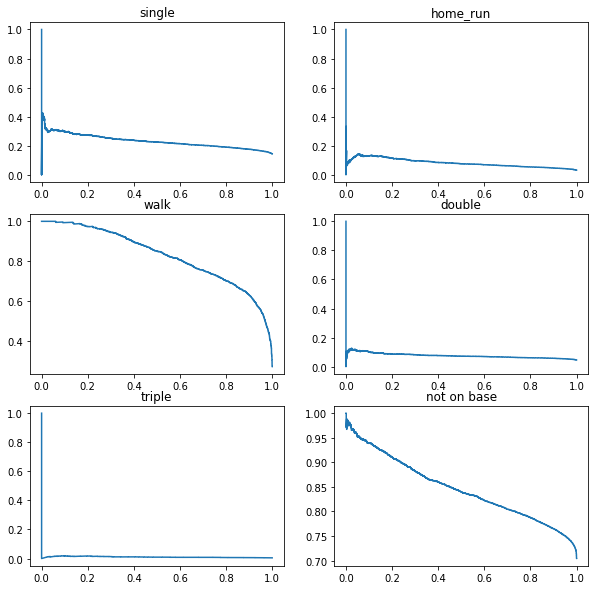

In [186]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
%matplotlib inline

fig, axs = plt.subplots(3, 2, figsize=(10, 10))

for ax_idx, (event, idx) in enumerate(target_events.items()):
    p, r, t = precision_recall_curve(y_all[:, idx], preds[:, idx])
    axs[ax_idx % 3, 0 if not ax_idx % 2 else 1].plot(r, p)
    axs[ax_idx % 3, 0 if not ax_idx % 2 else 1].set_title(event)

p, r, t = precision_recall_curve(y_all[:, 0], preds[:, 0])
axs[2, 1].plot(r, p)
_ = axs[2, 1].set_title('not on base')

## look at batters

### load batting averages

In [121]:
stats = pd.read_csv('baseballdatabank-2019.2/core/Batting.csv')
ids = pd.read_excel('/Users/dgates/Downloads/SFBB-Player-ID-Map.xlsx')
stats = stats.merge(ids, left_on='playerID', right_on='IDPLAYER')
stats = stats[stats.yearID == 2018]
stats.shape

(1205, 64)

In [122]:
stats['obp'] = (stats['H'] + stats['BB'] + stats['HBP']) / (stats['AB'] + stats['BB'] + stats['SF'] + stats['HBP'])
stats['1B'] = stats.H - (stats['2B'] - stats['3B'] - stats['HR'])
stats['slg'] = (stats['1B'] + (2*stats['2B']) + (3*stats['3B']) + (4*stats['HR'])) / stats.AB
stats['ops'] = stats.obp + stats.slg
stats['obp'].describe(), stats.slg.describe(), stats.ops.describe()

(count    894.000000
 mean       0.246772
 std        0.144538
 min        0.000000
 25%        0.166667
 50%        0.286870
 75%        0.332473
 max        1.000000
 Name: obp, dtype: float64, count    894.000000
 mean       0.350224
 std        0.257286
 min        0.000000
 25%        0.131480
 50%        0.388889
 75%        0.507328
 max        2.333333
 Name: slg, dtype: float64, count    894.000000
 mean       0.596996
 std        0.382150
 min        0.000000
 25%        0.324756
 50%        0.683477
 75%        0.836918
 max        3.000000
 Name: ops, dtype: float64)

In [123]:
def get_feature_embeddings(X, feature, model):
    input_ = encoder.transform(X)[f'{feature}_input']
    return get_embeddings(input_, model, feature)

def get_embeddings(X, model, feature):
    input_ = model.get_layer(f'{feature}_input').get_output_at(-1)
    encoding = model.get_layer(f'{feature}_embedding').get_output_at(-1)
    return keras.models.Model(inputs=input_, outputs=encoding).predict(X)

In [143]:
batters = df[['batter_id', 'batter_mlbname']].drop_duplicates()
batters = batters.merge(stats, left_on='batter_id', right_on='MLBID')
batters = batters[batters.AB > 100]
batter_embeddings = get_feature_embeddings(batters, 'batter_id', model)
batters['x'], batters['y'] = zip(*batter_embeddings.reshape((-1, 2)))

In [144]:
# https://gist.github.com/dela3499/e159b388258b5f1a7a3bac42fc0179fd

from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool, CategoricalColorMapper
from bokeh.io import output_notebook
from bokeh.transform import transform
output_notebook()

lookat = {
    'Mike Trout': 'red',
    'Christian Yelich': 'green',
    'Bryce Harper': 'orange',
    'Mookie Betts': 'pink',
    'Rhys Hoskins': 'purple',
    'Jean Segura': 'grey'
}

batters['sort_key'] = batters.batter_mlbname.isin(lookat)
batters.sort_values('sort_key', inplace=True)

source = ColumnDataSource(
        data=dict(
            x=batters.x,
            y=batters.y,
            desc=batters.batter_mlbname
        )
    )

hover = HoverTool(
        tooltips=[
            ("index", "$index"),
            ("(x,y)", "($x, $y)"),
            ("desc", "@desc"),
        ]
    )

p = figure(plot_width=700, plot_height=700, tools=[hover, 'tap', 'wheel_zoom'],
           title="Mouse over the dots")

transformer = CategoricalColorMapper(
    factors=list(lookat.keys()),
    palette=list(lookat.values()),
    nan_color='blue')
p.circle('x', 'y', size=10, source=source, fill_color=transform('desc', transformer))
show(p)


Loading BokehJS ...

In [145]:
# https://gist.github.com/dela3499/e159b388258b5f1a7a3bac42fc0179fd

from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool, LinearColorMapper, ColorBar
from bokeh.io import output_notebook
from bokeh.transform import transform
output_notebook()


lookat = 'ops'

source = ColumnDataSource(
        data=dict(
            x=batters.x,
            y=batters.y,
            desc=batters.batter_mlbname,
            slg=batters.slg,
            obp=batters.obp,
            ops=batters.ops,
            bats=batters.BATS
        )
    )

hover = HoverTool(
        tooltips=[
            ("index", "$index"),
            ("(x,y)", "($x, $y)"),
            ("desc", "@desc"),
        ]
    )

p = figure(plot_width=700, plot_height=700, tools=[hover, 'tap', 'wheel_zoom', 'box_zoom'],
           title="Mouse over the dots")

from bokeh.palettes import Viridis3, Viridis256

transformer = LinearColorMapper(
    palette=Viridis256, low=batters[lookat].min(), high=batters[lookat].max())
p.circle('x', 'y', size=10, source=source, fill_color={'field': lookat, 'transform': transformer})
color_bar = ColorBar(color_mapper=transformer, location=(0, 0))
p.add_layout(color_bar, 'right')
show(p)


Loading BokehJS ...

In [146]:
pitcher_weights = model.get_layer('final_transformation').get_weights()[0][-4:-2, :]
batter_weights = model.get_layer('final_transformation').get_weights()[0][-2:, :]

In [147]:
target_events

{'double': 2, 'home_run': 4, 'single': 1, 'triple': 3, 'walk': 5}

In [148]:
batters['p'] = np.dot(batters[['x', 'y']].values, batter_weights)[:, 1:].sum(axis=1)  # this is contribution of prob of on-base

In [149]:
# https://gist.github.com/dela3499/e159b388258b5f1a7a3bac42fc0179fd

from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool, LinearColorMapper, ColorBar
from bokeh.io import output_notebook
from bokeh.transform import transform
output_notebook()


lookat = 'p'

source = ColumnDataSource(
        data=dict(
            x=batters.x,
            y=batters.y,
            desc=batters.batter_mlbname,
            p=batters.p
        )
    )

hover = HoverTool(
        tooltips=[
            ("index", "$index"),
            ("(x,y)", "($x, $y)"),
            ("desc", "@desc"),
        ]
    )

p = figure(plot_width=700, plot_height=700, tools=[hover, 'tap', 'wheel_zoom', 'box_zoom'],
           title="Mouse over the dots")

from bokeh.palettes import Viridis3, Viridis256

transformer = LinearColorMapper(
    palette=Viridis256, low=batters[lookat].min(), high=batters[lookat].max())
p.circle('x', 'y', size=10, source=source, fill_color={'field': lookat, 'transform': transformer})
color_bar = ColorBar(color_mapper=transformer, location=(0, 0))
p.add_layout(color_bar, 'right')
show(p)


Loading BokehJS ...

## look at pitchers

In [138]:
from sklearn.manifold import TSNE
pitchers = df[['pitcher_id', 'player_name']].drop_duplicates()
pitcher_embeddings = get_feature_embeddings(pitchers, 'pitcher_id', model)
pitchers['x'], pitchers['y'] = zip(*pitcher_embeddings.reshape((-1, 2)))

In [139]:
# https://gist.github.com/dela3499/e159b388258b5f1a7a3bac42fc0179fd

from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool, CategoricalColorMapper
from bokeh.io import output_notebook
from bokeh.transform import transform

output_notebook()

lookat = {
    'Noah Syndergaard': 'red',
    'Clayton Kershaw': 'green',
    'Aaron Nola': 'orange',
    'Craig Kimbrel': 'pink'
}

pitchers['sort_key'] = pitchers.player_name.isin(lookat)
pitchers.sort_values('sort_key', inplace=True)

source = ColumnDataSource(
        data=dict(
            x=pitchers.x,
            y=pitchers.y,
            desc=pitchers.player_name
        )
    )

hover = HoverTool(
        tooltips=[
            ("index", "$index"),
            ("(x,y)", "($x, $y)"),
            ("desc", "@desc"),
        ]
    )

p = figure(plot_width=700, plot_height=700, tools=[hover, 'tap'],
           title="Mouse over the dots")

transformer = CategoricalColorMapper(
    factors=list(lookat.keys()),
    palette=list(lookat.values()),
    nan_color='blue')
p.circle('x', 'y', size=10, source=source, fill_color=transform('desc', transformer))
show(p)

Loading BokehJS ...

In [140]:
pitchers['p'] = np.dot(pitchers[['x', 'y']].values, pitcher_weights)[:, 0]

In [141]:
# https://gist.github.com/dela3499/e159b388258b5f1a7a3bac42fc0179fd

from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool, CategoricalColorMapper
from bokeh.io import output_notebook
from bokeh.transform import transform

output_notebook()

source = ColumnDataSource(
        data=dict(
            x=pitchers.x,
            y=pitchers.y,
            desc=pitchers.player_name,
            p=pitchers.p
        )
    )

hover = HoverTool(
        tooltips=[
            ("index", "$index"),
            ("(x,y)", "($x, $y)"),
            ("desc", "@desc"),
        ]
    )

p = figure(plot_width=700, plot_height=700, tools=[hover, 'tap'],
           title="Mouse over the dots")

from bokeh.palettes import Viridis3, Viridis256

transformer = LinearColorMapper(
    palette=Viridis256, low=pitchers['p'].min(), high=pitchers['p'].max())
p.circle('x', 'y', size=10, source=source, fill_color={'field': 'p', 'transform': transformer})
color_bar = ColorBar(color_mapper=transformer, location=(0, 0))
p.add_layout(color_bar, 'right')
show(p)

Loading BokehJS ...

In [142]:
pitchers.sort_values('p', ascending=False)

,pitcher_id,player_name,x,y,sort_key,p
112244,458924.0,Jonny Venters,-2.051344,1.446138,False,1.775395
6228,571561.0,Tony Cingrani,-1.310431,1.210470,False,1.341445
210303,424144.0,Oliver Perez,-1.282246,1.097330,False,1.249603
5206,448281.0,Sean Doolittle,-0.656949,1.249975,False,1.137587
315660,669203.0,Corbin Burnes,-0.951624,1.008786,False,1.067979
328041,457915.0,Javy Guerra,-0.457239,1.208113,False,1.036282
240015,620454.0,Jose Castillo,-0.562433,1.042240,False,0.953745
333876,645261.0,Sandy Alcantara,-1.065863,0.696121,False,0.882505
114655,621381.0,Matt Strahm,-1.491072,0.479270,False,0.876924
413,518553.0,Steve Cishek,-0.850624,0.785627,False,0.870676


## Look at attention

In [65]:
A = keras.models.Model(inputs=[numeric_input] + list(categorical_inputs), outputs=attention)

In [66]:
batch_idx = 7
bx, by = batches[batch_idx]
aa = A.predict(bx)
aa.shape

(6, 5, 1)

In [67]:
np.argsort(aa, axis=1)[:, ::-1, :]

array([[[4],
        [3],
        [2],
        [0],
        [1]],

       [[4],
        [3],
        [2],
        [0],
        [1]],

       [[4],
        [3],
        [2],
        [1],
        [0]],

       [[4],
        [3],
        [2],
        [1],
        [0]],

       [[4],
        [3],
        [2],
        [0],
        [1]],

       [[4],
        [3],
        [2],
        [0],
        [1]]])

In [68]:
p = model.predict(bx)

In [69]:
inverse_target_map = {v: k for k, v in target_events.items()}
def inverse_transform(X):
    d = pd.DataFrame(X['numeric_inputs'], columns=numeric_features)
    for f in categorical_features:
        d[f] = encoder.inverse_transform(pd.Series(X[f'{f}_input']), f)
    return d

In [71]:
idx = 5
d = inverse_transform({k: v[idx] for k, v in bx.items()})
d['attention'] = aa[idx].reshape(-1)
d = d.merge(batters[['batter_id', 'batter_mlbname']])
d = d.merge(pitchers[['pitcher', 'player_name']])

print('was', inverse_target_map.get(np.argmax(by[idx]), 'not on base event'))
print('predicted', inverse_target_map.get(np.argmax(p[idx]), 'not on base event'))

with pd.option_context('display.max_columns', None):
    display(d)

was not on base event
predicted not on base event


,bat_score,fld_score,balls,strikes,outs_when_up,pitch_number,inning,total_pitch_number,at_bat_number,if_fielding_alignment,of_fielding_alignment,inning_topbot,pitch_name,zone,pitcher,batter_id,game_type,stand,runner_on_first,runner_on_second,runner_on_third,away_team,home_team,attention,batter_mlbname,player_name
0,0,1,0,0,0,1,2,20,10,Standard,Standard,Top,Cutter,14.0,435221.0,656941.0,R,L,1,0,0,CHC,ATL,3.299295e-07,Kyle Schwarber,Brandon McCarthy
1,0,1,1,0,0,2,2,21,10,Standard,Standard,Top,Sinker,13.0,435221.0,656941.0,R,L,1,0,0,CHC,ATL,3.227115e-07,Kyle Schwarber,Brandon McCarthy
2,0,1,2,0,0,3,2,22,10,Standard,Standard,Top,Cutter,8.0,435221.0,656941.0,R,L,1,0,0,CHC,ATL,4.398473e-06,Kyle Schwarber,Brandon McCarthy
3,0,1,2,1,0,4,2,23,10,Standard,Standard,Top,Cutter,4.0,435221.0,656941.0,R,L,1,0,0,CHC,ATL,5.602702e-03,Kyle Schwarber,Brandon McCarthy
4,0,1,2,2,0,5,2,24,10,Standard,Standard,Top,Cutter,12.0,435221.0,656941.0,R,L,1,0,0,CHC,ATL,9.943922e-01,Kyle Schwarber,Brandon McCarthy


# counterfactuals

In [ ]:
from scipy.optimize import minimize
from sklearn.metrics import log_loss

def make_loss(model, y_new, x_old, lambda_):
    x_base = {k: v for k, v in x_old.items()}
    x_shape = x_base['numeric_inputs'].shape
    def loss(x):
        x = x.reshape(x_shape)
        x_base['numeric_inputs'] = x
        y_hat = model.predict(x_base).reshape(-1)
        L = lambda_ * log_loss(y_new, y_hat)
        d = np.sum((x - x_old['numeric_inputs']) ** 2)
        return L + d
    return loss

In [ ]:
batch_idx = 0
idx = 0
bx, by = batches[batch_idx]
x_old = {k: np.expand_dims(v[idx], 0) for k, v in bx.items()}
loss = make_loss(
    model,
    np.array([0, 0, 0, 0, 0, 1]),
    x_old,
    2)
minimize(loss, x_old['numeric_inputs'], method='Nelder-Mead')

In [ ]:
bx